In [167]:
import os
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import json
import spacy
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_lg")
import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import collections

# POS definitions 
see https://universaldependencies.org/u/pos/index.html

|Tag|Description|Tag|Description|
|--|--|--|--|
|ADJ | adjective|NUM| numeral|
|ADP| adposition|PART| particle|
|ADV| adverb|PRON| pronoun|
|AUX| auxiliary|PROPN| proper noun|
|CCONJ| coordinating conjunction|PUNCT| punctuation|
|DET| determiner|SCONJ| subordinating conjunction|
|INTJ| interjection|SYM| symbol|
|NOUN| noun|VERB| verb|
|X| other|||









-----

POS: The simple UPOS part-of-speech tag.

Dep: Syntactic dependency, i.e. the relation between tokens.

# Read Data from Dataset and unify text as corpus

In [124]:
# First read one of nvd json files
with open('data/nvdcve-1.1-2019.json') as f:
    cve_dict = json.load(f)

In [125]:
# extract description of vulnerability
corpus = ''
counter = 0
LIMIT = 500
detection_flag = 'BBBBBBBB'
for cve in cve_dict['CVE_Items']:
    cve_id = cve['cve']['CVE_data_meta']['ID'].replace('-','')
    desc_list = cve['cve']['description']['description_data']
    for desc in desc_list:
        sentences = desc['value'].split('. ')
        for sentence in sentences:
            corpus += f'{detection_flag}{cve_id} {sentence}\n'
    counter += 1
    if counter == LIMIT:
        break
# --------------------        
doc = nlp(corpus)
# --------------------

In [126]:
# Get the token text, part-of-speech tag and dependency label
df_pos = pd.DataFrame()
word_position = 0
data_id = ''
index_counter = 0
for token in doc:
    token_text = token.text
    token_pos = token.pos_
    token_dep = token.dep_
    if detection_flag in token_text:
        data_id = token_text.lstrip(detection_flag)
        continue
        
    df_pos.loc[index_counter, 'word'] = token_text
    df_pos.loc[index_counter, 'pos'] = token_pos
    df_pos.loc[index_counter, 'dep'] = token_dep
    df_pos.loc[index_counter,'indicator'] = 1
    df_pos.loc[index_counter,'data_id'] = data_id
    
    if token_text == '\n':
        df_pos.loc[index_counter, 'word_position'] = word_position
        word_position = 0
    else:
        df_pos.loc[index_counter, 'word_position'] = word_position
        word_position += 1
        
    index_counter += 1

In [127]:
df_pos

,word,pos,dep,indicator,data_id,word_position
0,Receipt,NOUN,nsubj,1.0,CVE20190001,0.0
1,of,ADP,prep,1.0,CVE20190001,1.0
2,a,DET,det,1.0,CVE20190001,2.0
3,malformed,ADJ,amod,1.0,CVE20190001,3.0
4,packet,NOUN,pobj,1.0,CVE20190001,4.0
...,...,...,...,...,...,...
30598,Notes,PROPN,ROOT,1.0,CVE20190700,0.0
30599,:,PUNCT,punct,1.0,CVE20190700,1.0
30600,none,NOUN,appos,1.0,CVE20190700,2.0
30601,.,PUNCT,punct,1.0,CVE20190700,3.0


In [128]:
df_pos.to_csv('data/all_words_matrix.csv')

# EDA

We would like to know which POS shows up more at which position in the sentence

In [129]:
df_sentence_struc = pd.DataFrame()
for index in df_pos.index:
    pos = df_pos.loc[index, 'pos']
    word = df_pos.loc[index, 'word']
    dep = df_pos.loc[index, 'dep']
    word_position = df_pos.loc[index, 'word_position']
    df_sentence_struc.loc[index,'word'] = word
    df_sentence_struc.loc[index,'dep'] = dep
    df_sentence_struc.loc[index, 'word_position'] = word_position
    df_sentence_struc.loc[index, pos] = 1

df_pos = df_pos.astype({'word_position':'int'})

In [130]:
df_sentence_struc.fillna(0, inplace=True)
# df_sentence_struc

In [131]:
df_sentence_struc.to_csv('data/pos_matrix.csv')

In [132]:
part_of_speach_position = pd.pivot_table(df_pos, values='indicator', index=['pos'],
                    columns=['word_position'], aggfunc=np.sum)
part_of_speach_position = part_of_speach_position.fillna(0).astype('int')
part_of_speach_position = part_of_speach_position.sort_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ascending=False)

In [133]:
part_of_speach_position.to_csv('data/part_of_speach_position.csv')

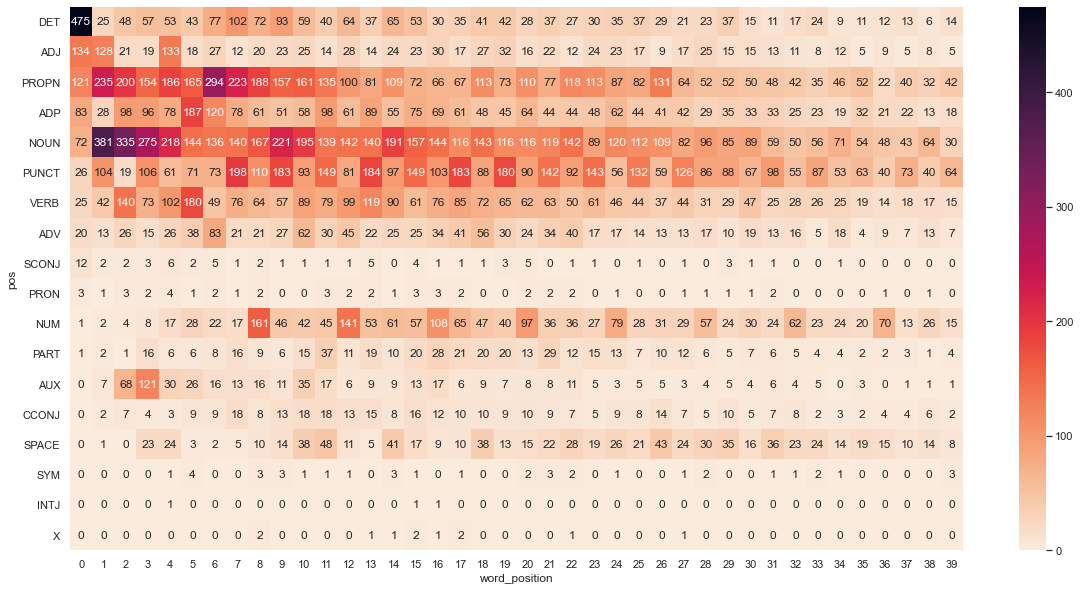

In [134]:
# visualization of POS vs POS position
plt.figure(figsize=(20,10))
ax = sns.heatmap(part_of_speach_position.iloc[:, 0:40], annot=True, cmap="rocket_r", fmt='d')

In [135]:
part_of_speach_position.iloc[:, 0:25]

word_position,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
pos,,,,,,,,,,,,,,,,,,,,,
DET,475,25,48,57,53,43,77,102,72,93,...,53,30,35,41,42,28,37,27,30,35
ADJ,134,128,21,19,133,18,27,12,20,23,...,23,30,17,27,32,16,22,12,24,23
PROPN,121,235,200,154,186,165,294,223,188,157,...,72,66,67,113,73,110,77,118,113,87
ADP,83,28,98,96,78,187,120,78,61,51,...,75,69,61,48,45,64,44,44,48,62
NOUN,72,381,335,275,218,144,136,140,167,221,...,157,144,116,143,116,116,119,142,89,120
PUNCT,26,104,19,106,61,71,73,198,110,183,...,149,103,183,88,180,90,142,92,143,56
VERB,25,42,140,73,102,180,49,76,64,57,...,61,76,85,72,65,62,63,50,61,46
ADV,20,13,26,15,26,38,83,21,21,27,...,25,34,41,56,30,24,34,40,17,17
SCONJ,12,2,2,3,6,2,5,1,2,1,...,4,1,1,1,3,5,0,1,1,0


In [201]:
list(part_of_speach_position.index)

['DET',
 'ADJ',
 'PROPN',
 'ADP',
 'NOUN',
 'PUNCT',
 'VERB',
 'ADV',
 'SCONJ',
 'PRON',
 'NUM',
 'PART',
 'AUX',
 'CCONJ',
 'SPACE',
 'SYM',
 'INTJ',
 'X']

------
Now we would like to know which POS is showing up the most in the corpus.

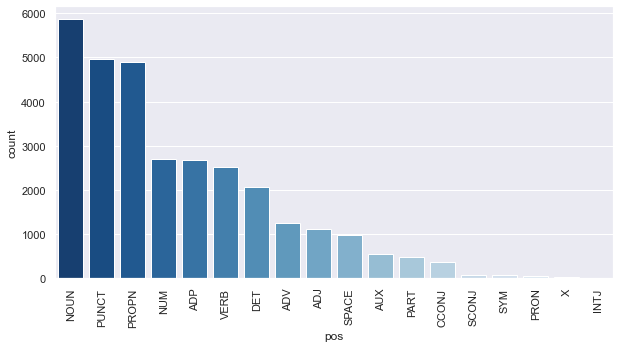

In [136]:
# POS count in the corpus
pos_count = df_pos.groupby(['pos']).count().sort_values(
    ['word'], ascending=False).drop(
    ['word', 'dep', 'word_position'], axis=1).rename(
    columns={'indicator':'count'}).sort_values('count', ascending=False).reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='pos', y='count', data=pos_count, palette="Blues_r")
plt.xticks(rotation=90);

-------
Here we will count which sequence of POS are showing up the most in the corpus.

In [137]:
# POS sequence
all_pos_seq = []
all_words_and_seq = []
single_pos_seq = ''
single_sentence = ''
for index in df_pos.index:
    pos = df_pos.loc[index, 'pos']
    word = df_pos.loc[index, 'word']
    word_position = df_pos.loc[index, 'word_position']
    
    if word_position == 0:
        if single_pos_seq != '':
            all_pos_seq.append(single_pos_seq)
            all_words_and_seq.append((single_pos_seq, single_sentence))
        single_pos_seq = pos
        single_sentence = word
    else:
        single_pos_seq += f'-{pos}'
        single_sentence += f'-{word}'

In [138]:
elements_count = collections.Counter(all_pos_seq)

In [139]:
most_common_pos = elements_count.most_common(3)
most_common_pos

[('PUNCT-PUNCT-VERB-PUNCT-PUNCT-VERB-ADV-VERB-DET-NOUN-NOUN-SPACE', 21),
 ('ADJ-PUNCT-NOUN-SPACE', 20),
 ('NOUN-PUNCT-DET-NOUN-AUX-ADP-DET-PROPN-NOUN-DET-AUX-PART-VERB-ADP-DET-NOUN-ADP-NUM-SPACE',
  19)]

In [140]:
for val in all_words_and_seq:
    if val[0] == most_common_pos[0][0]:
        print(val[1])
        print(val[0])
        break

*-*-REJECT-*-*-DO-NOT-USE-THIS-CANDIDATE-NUMBER-

PUNCT-PUNCT-VERB-PUNCT-PUNCT-VERB-ADV-VERB-DET-NOUN-NOUN-SPACE


---------------
Find phrases based on POS sequence

In [141]:
# Find POS sequence
def sequence_finder(user_pos_seq, fw_win=0, bck_win=0, stop=np.inf):
    counter = 0
    result_word_only = []
    result_pos_only = []
    result_all = []
    for index in df_pos.index:
        pos = df_pos.loc[index, 'pos']
        word = df_pos.loc[index, 'word']
        word_position = df_pos.loc[index, 'word_position']

        extracted_pos_seq = list(df_pos.iloc[index:index+len(user_pos_seq)]['pos'])

        if extracted_pos_seq == user_pos_seq:
            l = list(df_pos.iloc[index-bck_win:index+len(user_pos_seq)+fw_win]['word'])
            s = list(df_pos.iloc[index-bck_win:index+len(user_pos_seq)+fw_win]['pos'])
            msg = ' '.join(l)
            ps = '-'.join(s)
            result_word_only.append(msg)
            result_pos_only.append(ps)
            result_all.append((msg, ps))
            counter += 1
            if counter >= stop:
                break
    return collections.Counter(result_all)

In [142]:
result = sequence_finder(user_pos_seq=['ADJ', 'NOUN', 'NOUN'], fw_win=5, stop=2)
result.most_common(15)

[(('dynamic vlan configuration can trigger an uncontrolled recursion',
   'ADJ-NOUN-NOUN-VERB-VERB-DET-ADJ-NOUN'),
  1),
 (('uncontrolled recursion loop in the Broadband Edge subscriber',
   'ADJ-NOUN-NOUN-ADP-DET-PROPN-PROPN-NOUN'),
  1)]

In [143]:
result = sequence_finder(['AUX','VERB'], bck_win=5, stop=2)
result.most_common(15)

[(('a specific BGP flowspec configuration is enabled',
   'DET-ADJ-NOUN-NOUN-NOUN-AUX-VERB'),
  1),
 (('crash with a core file being generated',
   'VERB-ADP-DET-NOUN-NOUN-AUX-VERB'),
  1)]

In [144]:
result = sequence_finder(['VERB','VERB'])
result.most_common(15)

[(('may allow', 'VERB-VERB'), 103),
 (('can result', 'VERB-VERB'), 10),
 (('may cause', 'VERB-VERB'), 7),
 (('may crash', 'VERB-VERB'), 6),
 (('could allow', 'VERB-VERB'), 6),
 (('may lead', 'VERB-VERB'), 5),
 (('could execute', 'VERB-VERB'), 4),
 (('causing prolonged', 'VERB-VERB'), 3),
 (('can lead', 'VERB-VERB'), 3),
 (('can trigger', 'VERB-VERB'), 2),
 (('might crash', 'VERB-VERB'), 2),
 (('enabled may', 'VERB-VERB'), 2),
 (('can access', 'VERB-VERB'), 2),
 (('may fail', 'VERB-VERB'), 2),
 (('can cause', 'VERB-VERB'), 2)]

In [145]:
result = sequence_finder(['VERB','AUX','VERB'])
result.most_common(15)

[(('can be executed', 'VERB-AUX-VERB'), 6),
 (('could be used', 'VERB-AUX-VERB'), 5),
 (('will be executed', 'VERB-AUX-VERB'), 4),
 (('can be misused', 'VERB-AUX-VERB'), 3),
 (('can be used', 'VERB-AUX-VERB'), 2),
 (('can be exploited', 'VERB-AUX-VERB'), 2),
 (('can be identified', 'VERB-AUX-VERB'), 1),
 (('can be changed', 'VERB-AUX-VERB'), 1),
 (('should be dropped', 'VERB-AUX-VERB'), 1),
 (('can be crafted', 'VERB-AUX-VERB'), 1),
 (('will be logged', 'VERB-AUX-VERB'), 1),
 (('could be made', 'VERB-AUX-VERB'), 1),
 (('will be disclosed', 'VERB-AUX-VERB'), 1),
 (('must be compromised', 'VERB-AUX-VERB'), 1),
 (('can be overwritten', 'VERB-AUX-VERB'), 1)]

In [146]:
result = sequence_finder(['VERB','PART','VERB'])
result.most_common(15)

[(('fails to check', 'VERB-PART-VERB'), 3),
 (('destined to port', 'VERB-PART-VERB'), 2),
 (('fail to forward', 'VERB-PART-VERB'), 2),
 (('might not take', 'VERB-PART-VERB'), 1),
 (('will not show', 'VERB-PART-VERB'), 1),
 (('can not perform', 'VERB-PART-VERB'), 1),
 (('allowed to connect', 'VERB-PART-VERB'), 1),
 (('required to clear', 'VERB-PART-VERB'), 1),
 (('configured to respond', 'VERB-PART-VERB'), 1),
 (('listening to port', 'VERB-PART-VERB'), 1),
 (('required to restore', 'VERB-PART-VERB'), 1),
 (('used to confirm', 'VERB-PART-VERB'), 1),
 (('fails to handle', 'VERB-PART-VERB'), 1),
 (('lead to stack', 'VERB-PART-VERB'), 1),
 (('exploited to bypass', 'VERB-PART-VERB'), 1)]

In [147]:
result = sequence_finder(['ADJ', 'NOUN', 'NOUN', 'VERB','PART','VERB'])
result.most_common(15)

[]

In [229]:
# Find POS sequence
def get_sentence_range(start_index):
    for index in df_pos.iloc[start_index:].index:
        try:
            if df_pos.loc[index+1, 'word_position'] == 0:
                return index
        except KeyError:
            return None
    raise ValueError

def pos_to_char(seq):
    pos_dict = {
        'DET':'A',
        'ADJ':'B',
        'PROPN':'C',
        'ADP':'D',
        'NOUN':'E',
        'PUNCT':'F',
        'VERB':'G',
        'ADV':'H',
        'SCONJ':'I',
        'PRON':'J',
        'NUM':'K',
        'PART':'L',
        'AUX': 'M',
        'CCONJ':'N',
        'SPACE':'O',
        'SYM':'P',
        'INTJ':'Q',
        'X':'R'
    }
    new_seq = []
    for s in seq:
        new_seq.append(pos_dict[s])
    return new_seq

def find_triple_seq_in_single_sentence(sentence, seq_1, seq_2, seq_3):
    extracted_pos_seq = ''.join(pos_to_char(list(sentence['pos'])))
    extracted_word_seq = list(sentence['word'])
    
    s1 = ''.join(pos_to_char(seq_1))
    s2 = ''.join(pos_to_char(seq_2))
    s3 = ''.join(pos_to_char(seq_3))
    match = re.search(fr'.*?({s1}).*?({s2}).*?({s3})', extracted_pos_seq)
    
    try:
        g1 = extracted_word_seq[match.span(1)[0]:match.span(1)[1]]
    except AttributeError:
        g1 = None
    
    try:
        g2 = extracted_word_seq[match.span(2)[0]:match.span(2)[1]]
    except AttributeError:
        g2 = None
    
    try:
        g3 = extracted_word_seq[match.span(3)[0]:match.span(3)[1]]
    except AttributeError:
        g3 = None
    
    return (g1, g2, g3)
    
def to_string(seq):
    try:
        return ' '.join(seq)
    except TypeError:
        return ''
        
def sequence_finder(seq_1=None, 
                    seq_2=None, 
                    seq_3=None, stop=np.inf):
    counter = 0
    result_word_only = []
    result_pos_only = []
    result_all = []
    start_sentence = 0
    end_sentence = -1    
    
    continue_search = True
    
    while(continue_search):
        start_sentence = end_sentence + 1
        end_sentence = get_sentence_range(start_sentence)
        if end_sentence == None:
            end_sentence = len(df_pos)
            continue_search = False
            
        chunck = df_pos.iloc[start_sentence:end_sentence+1]
        
        g1, g2, g3 = find_triple_seq_in_single_sentence(chunck, seq_1, seq_2, seq_3)

        msg1 = to_string(g1)
        msg2 = to_string(g2)
        if seq_3 != None:
            msg3 = to_string(g3)
        else:
            msg3 = ''
        if msg1 != '':
            print(f'({msg1})--[{msg2}]-->({msg3})')
        
        counter += 1
        if counter >= stop:
            break

In [231]:
sequence_finder(seq_1=['ADJ', 'NOUN', 'NOUN'], 
                seq_2=['VERB','VERB'], 
                seq_3=['ADJ', 'NOUN'])

(dynamic vlan configuration)--[can trigger]-->(uncontrolled recursion)
(graceful restart helper)--[enabled may]-->(local routing)
(high default connection)--[may allow]-->(advanced scripting)
(strong password policy)--[can increase]-->(brute force)
(graceful restart helper)--[enabled may]-->(local routing)
(Insufficient access control)--[may allow]-->(unprivileged user)
(Improper data sanitization)--[may allow]-->(privileged user)
(Insufficient access control)--[may allow]-->(unauthenticated user)
(Insufficient input validation)--[may allow]-->(unauthenticated user)
(Insufficient data sanitization)--[may allow]-->(privileged user)
(Insufficient input validation)--[may allow]-->(unauthenticated user)
(Insufficient input validation)--[may allow]-->(privileged user)
(Insufficient access control)--[may allow]-->(unauthenticated user)
(Insufficient session authentication)--[may allow]-->(unauthenticated user)
(Insufficient file protection)--[may allow]-->(local access)
(Insufficient file pr